# Preparation

In this notebook we will be working on toy problem of reconstructing the hidden 
dependency. We will work with synthetic dataset. As a basic example, we will
start with data

$$f(x) = \sin(x) + \epsilon,$$

where $\epsilon$ is random noise that will simulate measurement inaccuracies.

Our task will be to prepare the network $Net(x)$ that will accept single value $x$
as an argument and yield single value $y$ as a forecast.

Ideally the network should be as close to the hidden dependency as possible:

$$Net(x) \rightarrow \sin(x)$$

# Generating the dataset

First we will generate the clean samples

In [13]:
import sys
print(sys.version)


3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]


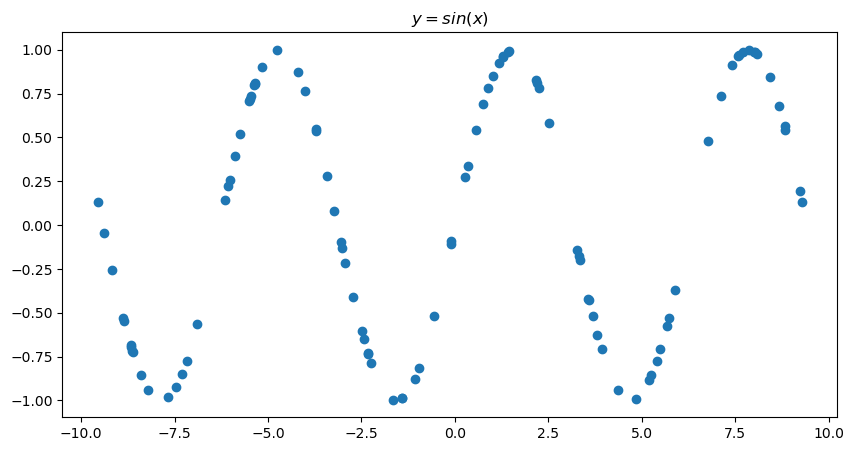

In [14]:
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

Secondly, generate the noise that will be added to the training data

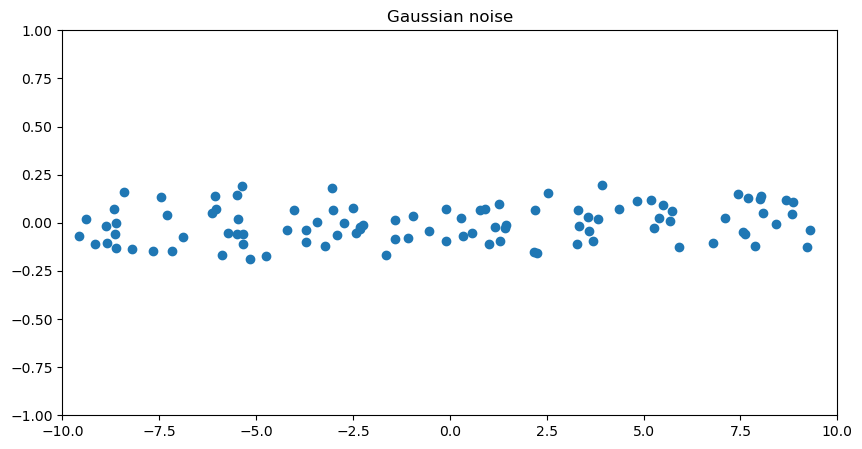

In [15]:
noise = torch.randn(y_train.shape) / 10.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

Lastly, add the noise to the clean data and get the spoiled data that we will use for training

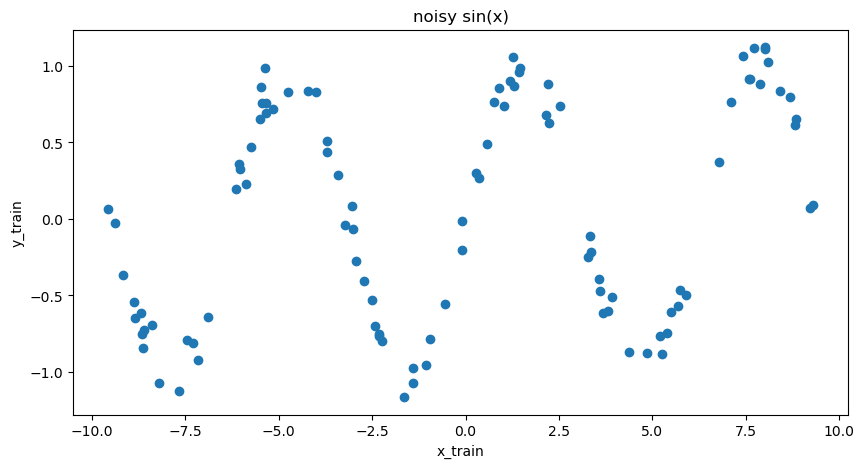

In [16]:
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

In [17]:
x_train.unsqueeze_(1);
y_train.unsqueeze_(1);

# Validation dataset

For validation we will use only clean equidistant data. Thus we will not generate noise for this set.

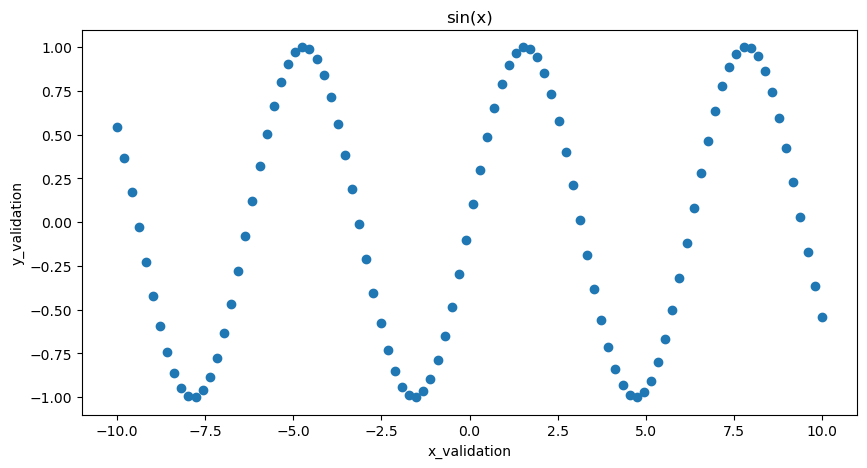

In [18]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [19]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

# Model construction

Fill out the class for 2-layer Feed Forward Neural Network with Sigmoid hidden layer.

Class should consist of two methods:
* `__init__` -- constructor, where the layers should be defined:
    * Linear 1 -> n_hidden_neurons
    * sigmoid activation
    * Linear n_hidden_neurons -> 1
* `forward` -- pass the signal through the network:
    * x -> linear 1 -> sigmoid -> linear 2

In [89]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)  # first hidden layer
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)  # second hidden layer
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)  # Output layer

    def forward(self, x):
        x = self.fc1(x)  
        x = self.act1(x)  
        x = self.fc2(x)  
        x = self.act2(x)  
        y = self.fc3(x)  
        return y

sine_net = SineNet(12)

# Prediction

Here we will make prediction using our neural network. The main method here is `forward` that we have programmed within our `torch.Module` class.

Below we will plot out predictions to understand how they are related to the validation data.

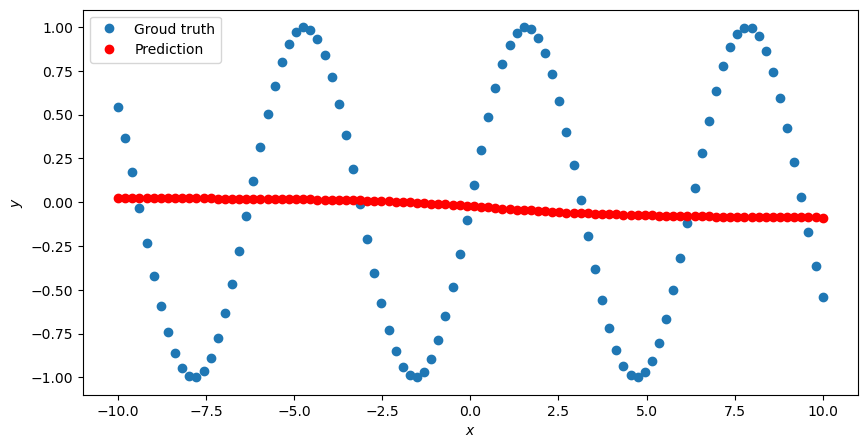

In [90]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)

We see that the untrained neural network predict something, maybe even some dependency, but it is not related to the dependency that we want to reconstruct. 

Now let us train the network (tune the parameters to minimize the misfit between the labels and predictions).

# Loss function

Now we will define the function using which we will measure the misfit.

The requirements for this function are:
* the lower the loss is the better the predictions are
* slope should be non-zero for the majority of the locations

In our case it will be mean squared error:
$$\frac{1}{N} \sum_{i=1}^N \left(Net(x_i) - t_i\right)^2$$

The lower this deviation is, the closer the prediction of the Neural Network to target.

Code this loss function. Note that `pred` and `target` are the vectors.

In [91]:
def loss(pred, target):
    result = torch.mean((pred - target) ** 2)
    return result

# Optimizer

Now we have to tune the parameters minimising the loss function. Select `Adam` optimizer from `torch.optim`.

As a first argument you should pass which parameters the optimizer should take care of. One can access whole set of parameters of `torch.Module` using `parameters()` method.

Set `lr` (learning rate) to `1.0e-2`.

In [92]:

from torch.optim import Adam

optimizer = Adam(params=sine_net.parameters(), lr=0.05)

# Training procedure

Now everything is ready for training.

Compound the training cycle out of the following step:
1. reset the gradients for trainable weights (`zero_grad()` method of the optimizer)
2. forward signal propagation through the network (take vector of input signals `x_train` and call `forward` method of the `torch.nn.Module` with that `x_train` as an argument)
3. loss value comutation (take`loss` that we have created above and comute misfit of prediction and target labels `y_train`)
4. backpropagation through the network, computation of loss derivatives through every of the weights of the network (`backward` method of `torch.nn.Module`)
5. optimizer step as all of the gradients for every of the weights are known (`step` method of the `Optimizer`)

Repeat the steps above for some amount of times. Say, for `1000` and observe the change of the network predictions

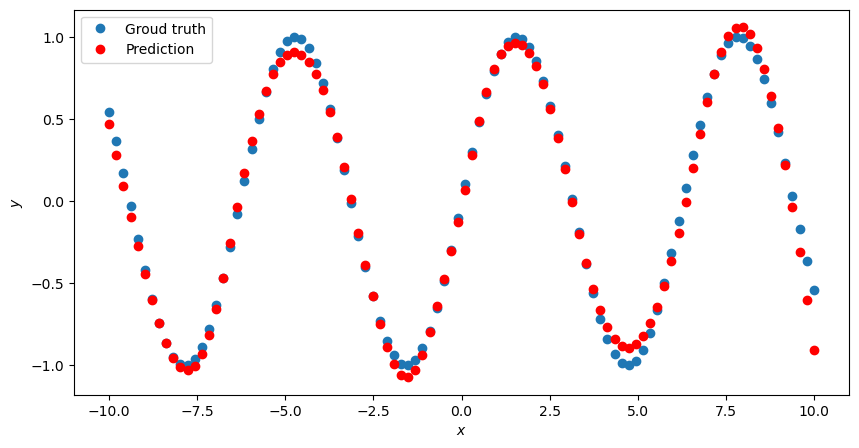

In [93]:
for epoch_index in range(10000):
    optimizer.zero_grad()
    y_pred = sine_net.forward(x_train)
    mse = loss(y_pred, y_train)
    mse.backward()
    optimizer.step()

predict(sine_net, x_validation, y_validation)

# Conclusion

In this notebook we have covered all of the steps that the coder encounters while programming training procedure of a Neural Network.

In serious projects every part of this process contatins tonns of code, but the philosophy everywhere is the same:

* Get data
* Define the Network
* Define Loss
* Select optimizer
* Run training cycle